In [ ]:
import pandas as pd

In [ ]:
import numpy as np

In [ ]:
from dynamic_portfolio.utils import load_csv
from dynamic_portfolio.utils import features_creation, clean_data
from dynamic_portfolio.preprocess import scaler

# Loading data and creating clean dataframe

In [ ]:
df = features_creation('META')

In [ ]:
pd.set_option('display.max_columns', None)

# Cross vals

We use sklearn's time series split to break up the data in different folds
We use a sklearn example to run the first tests.

Metrics used : 
 - rmse
 - mae
 - R2

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
ts_cv = TimeSeriesSplit(
    n_splits=20,
    gap=0,
    max_train_size=252,
    test_size=45,
)

In [ ]:
all_splits = list(ts_cv.split(X, y))

In [11]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [ ]:
model = HistGradientBoostingRegressor()

In [ ]:
rmse = []
for train_index, test_index in ts_cv.split(X):
    cv_train, cv_test = X.iloc[train_index], X.iloc[test_index]
    model = model.fit(X,y)
    predictions = model.predict(cv_test)
    true_values = cv_test['return']
    rmse.append(np.sqrt(mean_squared_error(true_values, predictions)))

In [ ]:
np.mean(rmse)*100

In [ ]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.6f} +/- {mae.std():.6f}\n"
        f"Root Mean Squared Error: {rmse.mean():.6f} +/- {rmse.std():.6f}"
    )


In [ ]:
import seaborn as sns

In [ ]:
evaluate(model, X, y, ts_cv)

# PCA Analysis

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=0.9)
ibm = prep.ready_to_train_df('IBM')
pca.fit(ibm)

In [ ]:
n_pcs= pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = ibm.columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

In [ ]:
most_important_names

## Using PCA analysis on all stocks

In [ ]:
from sklearn.pipeline import make_pipeline

In [ ]:
pipe.get_params()

In [ ]:
pipe = make_pipeline(PCA(), GradientBoostingRegressor())

params = {'pca__n_components':0.9,
                'gradientboostingregressor__max_depth':3,
                'gradientboostingregressor__criterion':'friedman_mse',
                'gradientboostingregressor__n_estimators':100,
                'gradientboostingregressor__learning_rate':0.08}
pipe.set_params(**params)

In [ ]:
pca_dict_score = {}
tickers = utils.return_tickers()
for ticker in tickers:
        dict_pca_score[ticker] = cross_validate_ml(prep.ready_to_train_df(ticker), pipe)
        print(f"done for ticker {ticker} index # {tickers.index(ticker)}")

In [ ]:
pca_dict_score = {}
tickers = utils.return_tickers()
for ticker in tickers:
    pca = PCA(n_components=0.9)
    ticker_df = prep.ready_to_train_df(ticker)
    pca.fit(ticker_df)
    n_pcs= pca.n_components_
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
    initial_feature_names = ticker_df.columns
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    pca_df = ticker_df[list(np.unique(most_important_names))] 
    returns = ticker_df[['return']]
    final_pca = pd.merge(pca_df, returns, how='outer', left_index=True, right_index=True)
    pca_dict_score[ticker] = cross_validate_ml(final_pca, GradientBoostingRegressor(max_depth = 3, 
                                                                                    criterion='friedman_mse',
                                                                                    learning_rate=0.08,
                                                                                    n_estimators = 100))
    print(f"done for ticker {ticker} index # {tickers.index(ticker)}")

In [ ]:
rmse_pca= []
baseline = []
for key in pca_dict_score.keys():
    rmse_pca.append(pca_dict_score[key][0])
    baseline.append(pca_dict_score[key][1])
print(np.mean(rmse_pca), np.mean(baseline) )

In [79]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

In [130]:
import pandas as pd
import numpy as np
import dynamic_portfolio.preprocess as prep
import dynamic_portfolio.utils as utils
import dynamic_portfolio.cross_validate as cv
from sklearn.ensemble import GradientBoostingRegressor
import warnings
%load_ext autoreload
%autoreload 2
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Cross validation functions

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
cross_val = {
    'fold_length' : 252, # Working days for 1 year
    'fold_stride' : 60, # Step between folds, here one quarter
    'train_test_ratio' : 0.7, # Split in fold
    'input_length' : 0, # Number of days to move back from last train_index, here 0
    'horizon' : 1, # Number of days ahead to make prediction, here 1
    'output_length' : 1, # Number of targets wanted
}
#Split the dataset by FOLDS
def get_folds(
    df: pd.DataFrame,
    fold_length = cross_val['fold_length'],
    fold_stride = cross_val['fold_stride']):
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    Returns a list of folds, each as a DataFrame
    '''
    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds
#Split FOLDS by Train et Test
#### FOR ONE FOLD !!!!!
def train_test_split(fold: pd.DataFrame,
                     train_test_ratio = cross_val['train_test_ratio'],
                     input_length = cross_val['input_length']):
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    '''
    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]
    # TEST SET
    # ======================
    first_test_idx = last_train_idx - input_length 
    fold_test = fold.iloc[first_test_idx:, :]
    return (fold_train, fold_test)
def cross_validate_ml(df, model) :
    '''
    get_folds() create many FOLDS, train_test_split() create a split on ONE FOLDS.
    The goal of this function is to make splits and sequences on each FOLDS.
    Then, apply a model.
    '''
    folds = get_folds(df, fold_length = cross_val['fold_length'], fold_stride = cross_val['fold_stride']) # 1 - Creating FOLDS
    scores =[]
    baseline = []
    for fold in folds:
        # 2 - CHRONOLOGICAL TRAIN TEST SPLIT of the current FOLD
        (fold_train, fold_test) = train_test_split(fold = fold,
                                                train_test_ratio = cross_val['train_test_ratio'],
                                                input_length = cross_val['input_length'] ,
                                                )
        # 3 - Scanninng fold_train and fold_test for SEQUENCES
        X_train, y_train = fold_train, fold_train[['return']].shift(1).replace(np.nan,0)
        X_test, y_test = fold_test, fold_test[['return']].shift(1).replace(np.nan,0)
        model.fit(X_train, y_train)
        rmse_model = (mean_squared_error(y_test, model.predict(X_test)))**0.5
        scores.append(rmse_model)
        rmse_baseline = mean_squared_error(y_test.iloc[[0]], y_train.iloc[[-1]])**0.5
        baseline.append(rmse_baseline)
    return np.mean(scores), np.mean(baseline)

### Script to run for model on all stocks

### Models used

In [2]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [ ]:
dict_score = {}
tickers = utils.return_tickers()
for ticker in tickers:
        dict_score[ticker] = cross_validate_ml(prep.ready_to_train_df(ticker), XGBRegressor())
        print(f"done for ticker {ticker} index # {tickers.index(ticker)}")

### Cross val scoring

In [ ]:
rmse= []
baseline = []
for key in dict_score.keys():
    rmse.append(dict_score[key][0])
    baseline.append(dict_score[key][1])
print(np.mean(rmse), np.mean(baseline) )

## Custom grid search

In [ ]:
max_depth = [2, 5, 8]
criterion = ['friedman_mse', 'squared_error', 'mse']
learning_rate=[0.01, 0.1, 0.2] 
n_estimators=[100, 200, 500]

In [ ]:
def custom_gridsearch(df, model, max_depth=[2,3,4], criterion = ['friedman_mse', 'squared_error', 'mse'], n_estimator=[50, 75, 100], learning_rate=[0.08, 0.1, 0.12], loss=['squared_error', 'absolute_error', 'huber']):
    counter = 0
    rmse = []
    baseline = []
    params = []
    for max_depth_i in max_depth:
        for criterion_i in criterion:
            for n_estimator_i in n_estimator:
                for learning_rate_i in learning_rate:
                    for loss_i in loss:
                        test = cross_validate_ml(df = df, model = model(max_depth=max_depth_i,
                                                                   criterion = criterion_i,
                                                                   n_estimators = n_estimator_i,
                                                                   learning_rate = learning_rate_i,
                                                                   loss = loss_i))
                        rmse.append(test[0])
                        baseline.append(test[1])
                        params.append((max_depth_i, criterion_i, n_estimator_i, learning_rate_i))
                        counter += 1
                        print(f'model {counter} done with parameters: max_depth = {max_depth_i}, criterion = {criterion_i}, estimators = {n_estimator_i}, learning rate = {learning_rate_i}, loss = {loss_i}, rmse = {test[0]}')
    idx_min = np.argmin(rmse)
    best_params = params[idx_min]
    
    return best_params, rmse, params

### Model results on one stock on a grid search

In [ ]:
gs_IP = custom_gridsearch(prep.ready_to_train_df('IP'), model = GradientBoostingRegressor)

In [ ]:
gs_IP

In [ ]:
np.mean(baseline)

### Saving models

In [ ]:
pipe = make_pipeline(PCA(), GradientBoostingRegressor())

params = {'pca__n_components':0.9,
                'gradientboostingregressor__max_depth':,
                'gradientboostingregressor__criterion':'friedman_mse',
                'gradientboostingregressor__n_estimators':100,
                'gradientboostingregressor__learning_rate':0.1}
pipe.set_params(**params)

In [ ]:
xgb_pipe = make_pipeline(PCA(), XGBRegressor())

params = {'pca__n_components':0.9,
                'xgbregressor__max_depth': 5,
                'xgbregressor__max_leaves':0,
                'xgbregressor__n_estimators':100,
                'xgbregressor__learning_rate':0.1}


In [ ]:
model = XGBRegressor()

In [ ]:
model.get_params()

In [ ]:
xgb_pipe.set_params(**params)

In [59]:
import joblib

In [ ]:
tickers = utils.return_tickers()
for ticker in tickers:
    model = pipe
    df = prep.ready_to_train_df(ticker)
    model.fit(df, df['return'])
    joblib.dump(model, f"../raw_data/models/{ticker}_XGBoostDefault.joblib")
    print(f"Model {ticker} index # {tickers.index(ticker)} saved")

In [ ]:
tickers = utils.return_tickers()
scores = []
for ticker in tickers:
    model = GradientBoostingRegressor()
    X_train = prep.ready_to_train_df(ticker)
    y_train = prep.ready_to_train_df(ticker)['return'].shift(1).replace(np.nan,0)
    X_test = prep.ready_to_test(ticker)
    y_test = prep.ready_to_test(ticker)['return'].shift(1).replace(np.nan,0)
    model.fit(X_train, y_train)
    error = (mean_squared_error(y_test, model.predict(X_test)))**0.5
    scores.append(error)
    print(f"error for {ticker}: {error}, index # {tickers.index(ticker)}")

In [ ]:
np.mean(scores)

In [ ]:
np.std(scores)

## Baseline calculation

In [ ]:
tickers = utils.return_tickers()
baseline = []
for ticker in tickers:
    df = prep.ready_to_test(ticker)
    for i in range(1, len(df), 1):
        error = (mean_squared_error(df.loc[i,['return']], df.loc[i-1,['return']]))**0.5
        baseline.append(error)
    print(f"baseline done for {ticker} index # {tickers.index(ticker)}")

In [ ]:
np.mean(baseline)



In [ ]:
np.std(baseline)

In [ ]:
model = joblib.load(f"../raw_data/models/QCOM_GradientBoostingRegressor_PCA.joblib")

In [ ]:
tickers = utils.return_tickers()
y_pred = []
for ticker in tickers:
    model = joblib.load(model, f"model/{ticker}_GradientBoostingRegressor_PCA.joblib")
    y_pred.append(model.predict(df))

In [35]:
ticker = 'WTW'
X_train = prep.ready_to_train_df(ticker)
y_train = prep.ready_to_train_df(ticker)['return'].shift(1).replace(np.nan,0)
X_test = prep.ready_to_test_df(ticker)
y_test = prep.ready_to_test_df(ticker)['return'].shift(1).replace(np.nan,0)

In [36]:
model = GradientBoostingRegressor()

In [37]:
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [38]:
pred_wtw = pd.DataFrame(model.predict(X_test), columns=[f"{ticker}"], index = X_test.index)

In [47]:
df_1 = pd.concat([df, pred_wtw], axis = 1)

In [48]:
df_1

,WTW
date,
2021-07-16,-0.004304
2021-07-19,0.002006
2021-07-20,-0.027596
2021-07-21,0.019297
2021-07-22,0.022737
...,...
2022-11-16,0.008243
2022-11-17,0.006935
2022-11-18,-0.000674


In [52]:
temp = [pred_wtw, pred_zts, pred]

In [55]:
df_3 = pd.concat(temp, axis=1)

In [56]:
df_3

,WTW,ZTS,AAPL
date,,,
2018-07-09,NaN,NaN,0.013787
2018-07-10,NaN,NaN,0.013746
2018-07-11,NaN,NaN,-0.001507
2018-07-12,NaN,NaN,-0.012839
2018-07-13,NaN,NaN,0.016576
...,...,...,...
2022-11-16,0.008243,0.024363,0.011724
2022-11-17,0.006935,-0.010172,-0.007757
2022-11-18,-0.000674,-0.031445,0.013579


In [39]:
pred_wtw

,WTW
date,
2021-07-16,-0.004304
2021-07-19,0.002006
2021-07-20,-0.027596
2021-07-21,0.019297
2021-07-22,0.022737
...,...
2022-11-16,0.008243
2022-11-17,0.006935
2022-11-18,-0.000674


In [34]:
pred_zts

,ZTS
date,
2020-12-24,-0.011570
2020-12-28,0.005519
2020-12-29,0.009949
2020-12-30,0.004380
2020-12-31,0.006858
...,...
2022-11-16,0.024363
2022-11-17,-0.010172
2022-11-18,-0.031445


In [26]:
y_test.index

DatetimeIndex(['2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12',
               '2018-07-13', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20',
               ...
               '2022-11-08', '2022-11-09', '2022-11-10', '2022-11-14',
               '2022-11-15', '2022-11-16', '2022-11-17', '2022-11-18',
               '2022-11-21', '2022-11-22'],
              dtype='datetime64[ns]', name='date', length=1086, freq=None)

In [29]:
pred_zts = pd.DataFrame(model.predict(X_test), columns=[f"{ticker}"], index = X_test.index)

In [83]:
pred

,AAPL
date,
2018-07-09,0.013787
2018-07-10,0.013746
2018-07-11,-0.001507
2018-07-12,-0.012839
2018-07-13,0.016576
...,...
2022-11-16,0.011724
2022-11-17,-0.007757
2022-11-18,0.013579


In [60]:
tickers = utils.return_tickers()
preds = []
for ticker in tickers:
    model = GradientBoostingRegressor()
    X_train = prep.ready_to_train_df(ticker)
    y_train = prep.ready_to_train_df(ticker)['return'].shift(1).replace(np.nan,0)
    X_test = prep.ready_to_test_df(ticker)
    y_test = prep.ready_to_test_df(ticker)['return'].shift(1).replace(np.nan,0)
    model.fit(X_train, y_train)
    joblib.dump(model, f"../raw_data/models/{ticker}_GradientBoostingDefault.joblib")
    pred_ticker = pd.DataFrame(model.predict(X_test),columns=[f"{ticker}"], index = X_test.index)
    preds.append(pred_ticker)
    print(f"ticker {ticker} done index # {tickers.index(ticker)}")

final_df = pd.concat(preds, axis=1)

    
    
    
    

ticker AAPL done index # 0
ticker MSFT done index # 1
ticker GOOG done index # 2
ticker AMZN done index # 3
ticker TSLA done index # 4
ticker UNH done index # 5
ticker XOM done index # 6
ticker JNJ done index # 7
ticker WMT done index # 8
ticker NVDA done index # 9
ticker JPM done index # 10
ticker V done index # 11
ticker CVX done index # 12
ticker PG done index # 13
ticker LLY done index # 14
ticker MA done index # 15
ticker HD done index # 16
ticker META done index # 17
ticker BAC done index # 18
ticker ABBV done index # 19
ticker PFE done index # 20
ticker KO done index # 21
ticker MRK done index # 22
ticker PEP done index # 23
ticker COST done index # 24
ticker ORCL done index # 25
ticker AVGO done index # 26
ticker TMO done index # 27
ticker MCD done index # 28
ticker CSCO done index # 29
ticker ACN done index # 30
ticker DHR done index # 31
ticker TMUS done index # 32
ticker ABT done index # 33
ticker WFC done index # 34
ticker DIS done index # 35
ticker LIN done index # 36
tick

ticker MKC done index # 296
ticker ETR done index # 297
ticker LUV done index # 298
ticker ULTA done index # 299
ticker AEE done index # 300
ticker MLM done index # 301
ticker FE done index # 302
ticker PFG done index # 303
ticker FRC done index # 304
ticker DTE done index # 305
ticker DAL done index # 306
ticker HBAN done index # 307
ticker IR done index # 308
ticker CTRA done index # 309
ticker ANSS done index # 310
ticker ACGL done index # 311
ticker PPL done index # 312
ticker RF done index # 313
ticker VRSN done index # 314
ticker LH done index # 315
ticker EXR done index # 316
ticker PWR done index # 317
ticker CF done index # 318
ticker CAH done index # 319
ticker CFG done index # 320
ticker XYL done index # 321
ticker HPE done index # 322
ticker EPAM done index # 323
ticker DOV done index # 324
ticker WAT done index # 325
ticker WRB done index # 326
ticker TDY done index # 327
ticker PAYC done index # 328
ticker ROL done index # 329
ticker NTRS done index # 330
ticker MRO done 

In [63]:
final_df

,AAPL,MSFT,GOOG,AMZN,TSLA,UNH,XOM,JNJ,WMT,NVDA,JPM,V,CVX,PG,LLY,MA,HD,META,BAC,ABBV,PFE,KO,MRK,PEP,COST,ORCL,AVGO,TMO,MCD,CSCO,ACN,DHR,TMUS,ABT,WFC,DIS,LIN,NEE,BMY,NKE,VZ,TXN,UPS,COP,ADBE,CMCSA,CRM,PM,MS,AMGN,SCHW,HON,RTX,QCOM,T,IBM,DE,CVS,LOW,GS,UNP,NFLX,LMT,CAT,AMD,INTC,ELV,SPGI,AXP,SBUX,INTU,BLK,ADP,GILD,PLD,MDT,BA,AMT,CI,GE,TJX,ISRG,C,AMAT,PYPL,MDLZ,CB,SYK,ADI,MMC,EOG,NOW,VRTX,MO,NOC,EL,REGN,PGR,BKNG,DUK,TGT,SLB,SO,MMM,ITW,ZTS,GD,APD,HUM,MRNA,BDX,CSX,WM,PNC,HCA,ETN,USB,FISV,SHW,OXY,CL,MU,CME,AON,LRCX,BSX,EQIX,TFC,PXD,CHTR,CCI,MET,ATVI,ICE,MPC,NSC,DG,GM,EMR,F,KLAC,MCO,FCX,KDP,MNST,MCK,VLO,ORLY,ADM,PSX,PSA,SRE,SNPS,MAR,D,GIS,AEP,AZO,KHC,APH,HSY,CNC,CTVA,EW,CTAS,A,ROP,JCI,CDNS,FDX,NXPI,AIG,KMB,AFL,HES,MSI,PAYX,DVN,TRV,BIIB,DXCM,SYY,LHX,RSG,ENPH,ECL,ADSK,MCHP,ANET,KMI,CMG,FTNT,AJG,STZ,TT,WMB,MSCI,O,IQV,TEL,ROST,PRU,EXC,PH,FIS,SPG,COF,NUE,XEL,HLT,CARR,PCAR,BK,NEM,DOW,EA,WBA,DD,ALL,YUM,AMP,CMI,ILMN,TDG,IDXX,ED,KR,ABC,DLTR,RMD,ALB,HAL,NDAQ,LVS,ODFL,WELL,AME,CSGP,OTIS,MTD,SBAC,ON,VICI,DLR,KEYS,PPG,WEC,CTSH,ROK,GWW,PCG,HPQ,FAST,DFS,MTB,PEG,OKE,DHI,APTV,BKR,GLW,LYB,ES,BAX,STT,VRSK,TROW,WBD,AWK,IT,GPN,HRL,FANG,WTW,RJF,GPC,IFF,CDW,TSCO,FITB,ARE,URI,ZBH,K,LEN,EBAY,EIX,CBRE,EFX,VMC,TSN,HIG,FTV,WY,EQR,AVB,MKC,ETR,LUV,ULTA,AEE,MLM,FE,PFG,FRC,DTE,DAL,HBAN,IR,CTRA,ANSS,ACGL,PPL,RF,VRSN,LH,EXR,PWR,CF,CAH,CFG,XYL,HPE,EPAM,DOV,WAT,WRB,TDY,PAYC,ROL,NTRS,MRO,CNP,INVH,CHD,AES,MOH,JBHT,MAA,BBY,CLX,HOLX,WAB,DRI,EXPD,STE,AMCR,VTR,IEX,CAG,CMS,KEY,MPWR,BALL,J,BR,GRMN,PKI,TTWO,INCY,FDS,MOS,SEDG,CINF,ABMD,DGX,WST,ATO,TRGP,BRO,SYF,FOX,FOXA,NTAP,FMC,EQT,OMC,SJM,LYV,CPB,HWM,CPRT,AVY,IRM,COO,ALGN,SWKS,EXPE,RCL,ETSY,APA,GEN,TXT,LDOS,LKQ,TER,PTC,TRMB,AKAM,NVR,UAL,LNT,FLT,KIM,ZBRA,TYL,DPZ,JKHY,MGM,ESS,L,PEAK,MTCH,NDSN,EVRG,IPG,BEN,CBOE,TECH,SIVB,VFC,IP,HST,UDR,POOL,RE,PARA,SNA,CPT,LW,PKG,CRL,SWK,BIO,WDC,CHRW,STX,MAS,GL,CE,REG,NI,BXP,HSIC,CCL,TFX,CZR,NWS,NWSA,KMX,EMN,JNPR,PHM,CDAY,ALLE,QRVO,BWA,NRG,MKTX,WRK,UHS,FFIV,AOS,CMA,AAL,BBWI,HII,AAP,TPR,FRT,IVZ,PNW,HAS,WYNN,FBHS,SBNY,DISH,RHI,WHR,ZION,CTLT,PNR,SEE,RL,NCLH,DXC,GNRC,AIZ,XRAY,LNC,DVA,MHK,LUMN,ALK,NWL,VNO,TAP
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [115]:
filtered = final_df.loc['2021-01-04':].dropna(axis=1)

In [116]:
filtered

,AAPL,MSFT,AMZN,TSLA,UNH,XOM,JNJ,WMT,NVDA,JPM,V,CVX,PG,LLY,MA,HD,META,BAC,ABBV,PFE,KO,MRK,PEP,COST,ORCL,AVGO,TMO,MCD,CSCO,ACN,DHR,TMUS,ABT,WFC,DIS,NEE,BMY,NKE,VZ,TXN,UPS,COP,ADBE,CMCSA,CRM,PM,MS,AMGN,SCHW,HON,RTX,QCOM,T,IBM,DE,CVS,LOW,GS,UNP,NFLX,LMT,CAT,AMD,INTC,ELV,SPGI,AXP,SBUX,INTU,BLK,ADP,GILD,PLD,MDT,BA,AMT,CI,GE,TJX,ISRG,C,AMAT,MDLZ,CB,SYK,ADI,MMC,EOG,NOW,VRTX,MO,NOC,EL,REGN,PGR,BKNG,DUK,TGT,SLB,SO,MMM,ITW,ZTS,GD,APD,HUM,BDX,CSX,WM,PNC,HCA,ETN,USB,FISV,SHW,OXY,CL,MU,CME,AON,LRCX,BSX,EQIX,TFC,PXD,CHTR,CCI,MET,ATVI,ICE,MPC,NSC,DG,GM,EMR,F,KLAC,MCO,FCX,KDP,MNST,MCK,VLO,ORLY,ADM,PSX,PSA,SRE,SNPS,MAR,D,GIS,AEP,AZO,APH,HSY,CNC,EW,CTAS,A,ROP,JCI,CDNS,FDX,NXPI,AIG,KMB,AFL,HES,MSI,PAYX,DVN,TRV,BIIB,DXCM,SYY,LHX,RSG,ENPH,ECL,ADSK,MCHP,KMI,CMG,FTNT,AJG,STZ,TT,WMB,MSCI,O,TEL,ROST,PRU,EXC,PH,FIS,SPG,COF,NUE,XEL,PCAR,BK,NEM,EA,WBA,DD,ALL,YUM,AMP,CMI,ILMN,TDG,IDXX,ED,KR,ABC,DLTR,RMD,ALB,HAL,NDAQ,LVS,ODFL,WELL,AME,CSGP,MTD,SBAC,ON,DLR,PPG,WEC,CTSH,ROK,GWW,PCG,HPQ,FAST,DFS,MTB,PEG,OKE,DHI,APTV,GLW,LYB,ES,BAX,STT,VRSK,TROW,AWK,IT,GPN,HRL,FANG,RJF,GPC,IFF,TSCO,FITB,ARE,URI,ZBH,K,LEN,EBAY,EIX,CBRE,EFX,VMC,TSN,HIG,WY,EQR,AVB,MKC,ETR,LUV,ULTA,AEE,MLM,FE,PFG,FRC,DTE,DAL,HBAN,CTRA,ANSS,ACGL,PPL,RF,VRSN,LH,EXR,PWR,CF,CAH,XYL,EPAM,DOV,WAT,WRB,TDY,ROL,NTRS,MRO,CNP,CHD,AES,MOH,JBHT,MAA,BBY,CLX,HOLX,WAB,DRI,EXPD,STE,VTR,IEX,CAG,CMS,KEY,MPWR,BALL,J,BR,GRMN,PKI,TTWO,INCY,FDS,MOS,CINF,ABMD,DGX,WST,ATO,TRGP,BRO,NTAP,FMC,EQT,OMC,SJM,LYV,CPB,HWM,CPRT,AVY,IRM,COO,ALGN,SWKS,EXPE,RCL,APA,GEN,TXT,LDOS,LKQ,TER,PTC,TRMB,AKAM,NVR,UAL,LNT,FLT,KIM,ZBRA,TYL,DPZ,JKHY,MGM,ESS,L,PEAK,NDSN,IPG,BEN,CBOE,TECH,SIVB,VFC,IP,HST,UDR,POOL,RE,PARA,SNA,CPT,PKG,CRL,SWK,BIO,WDC,CHRW,STX,MAS,GL,CE,REG,NI,BXP,HSIC,CCL,TFX,KMX,EMN,JNPR,PHM,BWA,NRG,MKTX,UHS,FFIV,AOS,CMA,AAL,BBWI,HII,AAP,TPR,FRT,IVZ,PNW,HAS,WYNN,FBHS,SBNY,DISH,RHI,WHR,ZION,PNR,SEE,RL,NCLH,GNRC,AIZ,XRAY,LNC,DVA,MHK,LUMN,ALK,NWL,VNO,TAP
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,-0.008139,0.002909,-0.008683,0.016221,0.016419,-0.009298,0.008098,0.000168,-0.005837,0.012909,0.002186,-0.010116,0.010226,0.011668,0.003889,0.002016,0.005004,0.010581,0.018126,0.003083,0.006907,0.014870,0.006258,0.006004,0.003696,0.006689,0.008598,0.014553,0.006363,0.013751,0.006998,0.011353,0.009370,0.014833,-0.002011,0.015894,0.009176,-0.000884,0.011286,0.008230,0.012742,-0.000596,0.005024,0.023110,0.000699,0.015576,0.010532,0.012206,0.012088,0.008314,0.001918,0.015099,0.009214,0.012319,0.010719,0.008519,0.000262,0.016966,0.011093,0.031698,0.002544,0.011414,-0.005275,0.022606,0.022767,0.015771,0.012722,0.010345,0.011501,0.017844,0.013924,0.028156,0.009079,0.013277,-0.012090,0.019291,0.021296,0.008235,-0.000238,0.003766,0.013040,-0.008221,0.008225,0.012970,0.012323,0.010326,0.017165,-0.013661,0.005704,0.015061,0.006507,0.006921,0.013930,0.011806,0.014615,0.009960,0.011536,0.015323,-0.001800,0.014144,0.004117,0.008162,0.007575,0.003534,0.012872,0.009779,0.013809,0.004771,0.008305,0.014079,0.012958,0.006861,0.008990,0.008930,0.010209,-0.034585,0.009433,0.045204,0.021707,0.022278,-0.026325,0.011011,0.020028,0.007705,-0.005720,0.011463,0.018541,0.012543,0.012056,0.019131,-0.004714,0.007443,0.002909,-0.005612,0.007786,-0.007159,-0.004820,0.017362,-0.019151,0.006075,0.011816,0.002220,-0.002230,0.001729,0.009890,-0.009736,0.009218,0.013217,0.009032,0.010430,0.015209,0.004355,0.021278,0.007349,0.007707,0.012055,0.019004,0.018506,0.008941,0.009219,0.021561,0.003990,0.008613,-0.001359,-0.003466,0.008628,0.012207,0.011927,-0.019059,0.017835,0.011665,-0.020275,0.009601,0.005500,0.017580,0.013153,0.007556,0.010255,0.014094,0.004590,0.01

In [76]:
super_filtered = filtered.dropna(axis=1)

In [93]:
super_filtered

,AAPL,MSFT,AMZN,TSLA,UNH,XOM,JNJ,WMT,NVDA,JPM,V,CVX,PG,LLY,MA,HD,META,BAC,ABBV,PFE,KO,MRK,PEP,COST,ORCL,AVGO,TMO,MCD,CSCO,ACN,DHR,TMUS,ABT,WFC,DIS,NEE,BMY,NKE,VZ,TXN,UPS,COP,ADBE,CMCSA,CRM,PM,MS,AMGN,SCHW,HON,RTX,QCOM,T,IBM,DE,CVS,LOW,GS,UNP,NFLX,LMT,CAT,AMD,INTC,ELV,SPGI,AXP,SBUX,INTU,BLK,ADP,GILD,PLD,MDT,BA,AMT,CI,GE,TJX,ISRG,C,AMAT,MDLZ,CB,SYK,ADI,MMC,EOG,NOW,VRTX,MO,NOC,EL,REGN,PGR,BKNG,DUK,TGT,SLB,SO,MMM,ITW,ZTS,GD,APD,HUM,BDX,CSX,WM,PNC,HCA,ETN,USB,FISV,SHW,OXY,CL,MU,CME,AON,LRCX,BSX,EQIX,TFC,PXD,CHTR,CCI,MET,ATVI,ICE,MPC,NSC,DG,GM,EMR,F,KLAC,MCO,FCX,KDP,MNST,MCK,VLO,ORLY,ADM,PSX,PSA,SRE,SNPS,MAR,D,GIS,AEP,AZO,APH,HSY,CNC,EW,CTAS,A,ROP,JCI,CDNS,FDX,NXPI,AIG,KMB,AFL,HES,MSI,PAYX,DVN,TRV,BIIB,DXCM,SYY,LHX,RSG,ENPH,ECL,ADSK,MCHP,KMI,CMG,FTNT,AJG,STZ,TT,WMB,MSCI,O,TEL,ROST,PRU,EXC,PH,FIS,SPG,COF,NUE,XEL,PCAR,BK,NEM,EA,WBA,DD,ALL,YUM,AMP,CMI,ILMN,TDG,IDXX,ED,KR,ABC,DLTR,RMD,ALB,HAL,NDAQ,LVS,ODFL,WELL,AME,CSGP,MTD,SBAC,ON,DLR,PPG,WEC,CTSH,ROK,GWW,PCG,HPQ,FAST,DFS,MTB,PEG,OKE,DHI,APTV,GLW,LYB,ES,BAX,STT,VRSK,TROW,AWK,IT,GPN,HRL,FANG,RJF,GPC,IFF,TSCO,FITB,ARE,URI,ZBH,K,LEN,EBAY,EIX,CBRE,EFX,VMC,TSN,HIG,WY,EQR,AVB,MKC,ETR,LUV,ULTA,AEE,MLM,FE,PFG,FRC,DTE,DAL,HBAN,CTRA,ANSS,ACGL,PPL,RF,VRSN,LH,EXR,PWR,CF,CAH,XYL,EPAM,DOV,WAT,WRB,TDY,ROL,NTRS,MRO,CNP,CHD,AES,MOH,JBHT,MAA,BBY,CLX,HOLX,WAB,DRI,EXPD,STE,VTR,IEX,CAG,CMS,KEY,MPWR,BALL,J,BR,GRMN,PKI,TTWO,INCY,FDS,MOS,CINF,ABMD,DGX,WST,ATO,TRGP,BRO,NTAP,FMC,EQT,OMC,SJM,LYV,CPB,HWM,CPRT,AVY,IRM,COO,ALGN,SWKS,EXPE,RCL,APA,GEN,TXT,LDOS,LKQ,TER,PTC,TRMB,AKAM,NVR,UAL,LNT,FLT,KIM,ZBRA,TYL,DPZ,JKHY,MGM,ESS,L,PEAK,NDSN,IPG,BEN,CBOE,TECH,SIVB,VFC,IP,HST,UDR,POOL,RE,PARA,SNA,CPT,PKG,CRL,SWK,BIO,WDC,CHRW,STX,MAS,GL,CE,REG,NI,BXP,HSIC,CCL,TFX,KMX,EMN,JNPR,PHM,BWA,NRG,MKTX,UHS,FFIV,AOS,CMA,AAL,BBWI,HII,AAP,TPR,FRT,IVZ,PNW,HAS,WYNN,FBHS,SBNY,DISH,RHI,WHR,ZION,PNR,SEE,RL,NCLH,GNRC,AIZ,XRAY,LNC,DVA,MHK,LUMN,ALK,NWL,VNO,TAP
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,-0.008139,0.002909,-0.008683,0.016221,0.016419,-0.009298,0.008098,0.000168,-0.005837,0.012909,0.002186,-0.010116,0.010226,0.011668,0.003889,0.002016,0.005004,0.010581,0.018126,0.003083,0.006907,0.014870,0.006258,0.006004,0.003696,0.006689,0.008598,0.014553,0.006363,0.013751,0.006998,0.011353,0.009370,0.014833,-0.002011,0.015894,0.009176,-0.000884,0.011286,0.008230,0.012742,-0.000596,0.005024,0.023110,0.000699,0.015576,0.010532,0.012206,0.012088,0.008314,0.001918,0.015099,0.009214,0.012319,0.010719,0.008519,0.000262,0.016966,0.011093,0.031698,0.002544,0.011414,-0.005275,0.022606,0.022767,0.015771,0.012722,0.010345,0.011501,0.017844,0.013924,0.028156,0.009079,0.013277,-0.012090,0.019291,0.021296,0.008235,-0.000238,0.003766,0.013040,-0.008221,0.008225,0.012970,0.012323,0.010326,0.017165,-0.013661,0.005704,0.015061,0.006507,0.006921,0.013930,0.011806,0.014615,0.009960,0.011536,0.015323,-0.001800,0.014144,0.004117,0.008162,0.007575,0.003534,0.012872,0.009779,0.013809,0.004771,0.008305,0.014079,0.012958,0.006861,0.008990,0.008930,0.010209,-0.034585,0.009433,0.045204,0.021707,0.022278,-0.026325,0.011011,0.020028,0.007705,-0.005720,0.011463,0.018541,0.012543,0.012056,0.019131,-0.004714,0.007443,0.002909,-0.005612,0.007786,-0.007159,-0.004820,0.017362,-0.019151,0.006075,0.011816,0.002220,-0.002230,0.001729,0.009890,-0.009736,0.009218,0.013217,0.009032,0.010430,0.015209,0.004355,0.021278,0.007349,0.007707,0.012055,0.019004,0.018506,0.008941,0.009219,0.021561,0.003990,0.008613,-0.001359,-0.003466,0.008628,0.012207,0.011927,-0.019059,0.017835,0.011665,-0.020275,0.009601,0.005500,0.017580,0.013153,0.007556,0.010255,0.014094,0.004590,0.01

In [78]:
super_filtered.to_csv('preds_to_use.csv')

In [80]:
apple_return = prep.ready_to_test_df('AAPL')

In [99]:
apple_return 

,return
date,
2018-07-09,0.013885
2018-07-10,-0.001207
2018-07-11,-0.012976
2018-07-12,0.016766
2018-07-13,0.001570
...,...
2022-11-16,-0.008331
2022-11-17,0.012971
2022-11-18,0.003782


In [100]:
apple_return = apple_return.loc['2021-01-04':]

In [108]:
apple_return

,return
date,
2021-01-04,-0.024719
2021-01-05,0.012364
2021-01-06,-0.033662
2021-01-07,0.034123
2021-01-08,0.008631
...,...
2022-11-16,-0.008331
2022-11-17,0.012971
2022-11-18,0.003782


In [107]:
pred_to_graph

,AAPL
date,
2021-01-04,-0.007563
2021-01-05,-0.025055
2021-01-06,0.012138
2021-01-07,-0.032972
2021-01-08,0.033519
...,...
2022-11-16,0.011724
2022-11-17,-0.007757
2022-11-18,0.013579


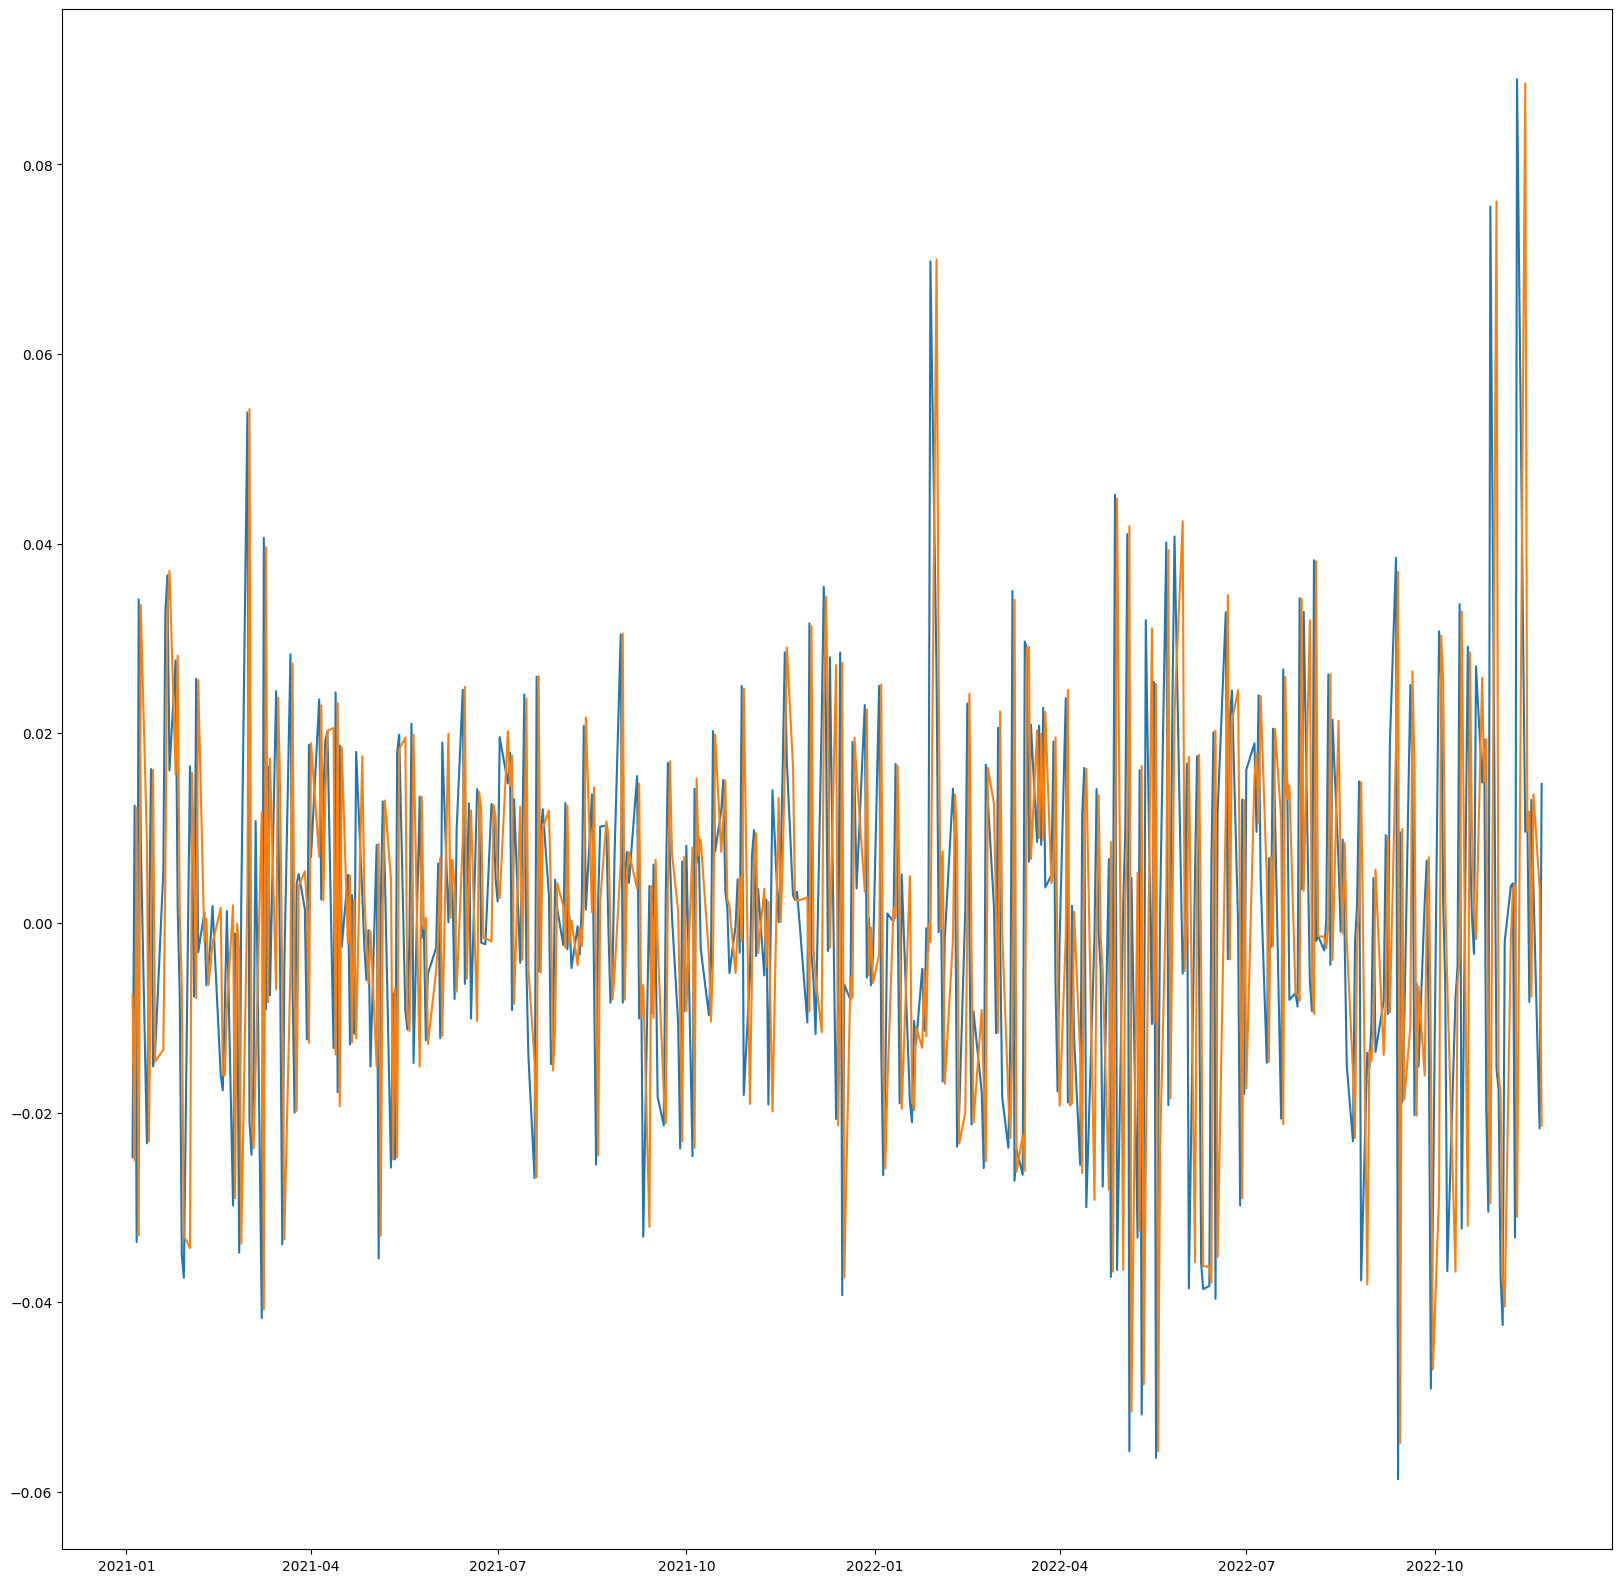

In [119]:
plt.figure(figsize=(20,20))
plt.plot(apple_return)
plt.plot(pred_to_graph)


In [124]:
preds = pd.read_csv('../raw_data/results/XGBDefault_preds_to_use.csv')

In [134]:
preds

,date,AAPL,MSFT,AMZN,TSLA,UNH,XOM,JNJ,WMT,NVDA,JPM,V,CVX,PG,LLY,MA,HD,META,BAC,ABBV,PFE,KO,MRK,PEP,COST,ORCL,AVGO,TMO,MCD,CSCO,ACN,DHR,TMUS,ABT,WFC,DIS,NEE,BMY,NKE,VZ,TXN,UPS,COP,ADBE,CMCSA,CRM,PM,MS,AMGN,SCHW,HON,RTX,QCOM,T,IBM,DE,CVS,LOW,GS,UNP,NFLX,LMT,CAT,AMD,INTC,ELV,SPGI,AXP,SBUX,INTU,BLK,ADP,GILD,PLD,MDT,BA,AMT,CI,GE,TJX,ISRG,C,AMAT,MDLZ,CB,SYK,ADI,MMC,EOG,NOW,VRTX,MO,NOC,EL,REGN,PGR,BKNG,DUK,TGT,SLB,SO,MMM,ITW,ZTS,GD,APD,HUM,BDX,CSX,WM,PNC,HCA,ETN,USB,FISV,SHW,OXY,CL,MU,CME,AON,LRCX,BSX,EQIX,TFC,PXD,CHTR,CCI,MET,ATVI,ICE,MPC,NSC,DG,GM,EMR,F,KLAC,MCO,FCX,KDP,MNST,MCK,VLO,ORLY,ADM,PSX,PSA,SRE,SNPS,MAR,D,GIS,AEP,AZO,APH,HSY,CNC,EW,CTAS,A,ROP,JCI,CDNS,FDX,NXPI,AIG,KMB,AFL,HES,MSI,PAYX,DVN,TRV,BIIB,DXCM,SYY,LHX,RSG,ENPH,ECL,ADSK,MCHP,KMI,CMG,FTNT,AJG,STZ,TT,WMB,MSCI,O,TEL,ROST,PRU,EXC,PH,FIS,SPG,COF,NUE,XEL,PCAR,BK,NEM,EA,WBA,DD,ALL,YUM,AMP,CMI,ILMN,TDG,IDXX,ED,KR,ABC,DLTR,RMD,ALB,HAL,NDAQ,LVS,ODFL,WELL,AME,CSGP,MTD,SBAC,ON,DLR,PPG,WEC,CTSH,ROK,GWW,PCG,HPQ,FAST,DFS,MTB,PEG,OKE,DHI,APTV,GLW,LYB,ES,BAX,STT,VRSK,TROW,AWK,IT,GPN,HRL,FANG,RJF,GPC,IFF,TSCO,FITB,ARE,URI,ZBH,K,LEN,EBAY,EIX,CBRE,EFX,VMC,TSN,HIG,WY,EQR,AVB,MKC,ETR,LUV,ULTA,AEE,MLM,FE,PFG,FRC,DTE,DAL,HBAN,CTRA,ANSS,ACGL,PPL,RF,VRSN,LH,EXR,PWR,CF,CAH,XYL,EPAM,DOV,WAT,WRB,TDY,ROL,NTRS,MRO,CNP,CHD,AES,MOH,JBHT,MAA,BBY,CLX,HOLX,WAB,DRI,EXPD,STE,VTR,IEX,CAG,CMS,KEY,MPWR,BALL,J,BR,GRMN,PKI,TTWO,INCY,FDS,MOS,CINF,ABMD,DGX,WST,ATO,TRGP,BRO,NTAP,FMC,EQT,OMC,SJM,LYV,CPB,HWM,CPRT,AVY,IRM,COO,ALGN,SWKS,EXPE,RCL,APA,GEN,TXT,LDOS,LKQ,TER,PTC,TRMB,AKAM,NVR,UAL,LNT,FLT,KIM,ZBRA,TYL,DPZ,JKHY,MGM,ESS,L,PEAK,NDSN,IPG,BEN,CBOE,TECH,SIVB,VFC,IP,HST,UDR,POOL,RE,PARA,SNA,CPT,PKG,CRL,SWK,BIO,WDC,CHRW,STX,MAS,GL,CE,REG,NI,BXP,HSIC,CCL,TFX,KMX,EMN,JNPR,PHM,BWA,NRG,MKTX,UHS,FFIV,AOS,CMA,AAL,BBWI,HII,AAP,TPR,FRT,IVZ,PNW,HAS,WYNN,FBHS,SBNY,DISH,RHI,WHR,ZION,PNR,SEE,RL,NCLH,GNRC,AIZ,XRAY,LNC,DVA,MHK,LUMN,ALK,NWL,VNO,TAP
0,2021-01-04,-0.008139,0.002909,-0.008683,0.016221,0.016419,-0.009298,0.008098,0.000168,-0.005837,0.012909,0.002186,-0.010116,0.010226,0.011668,0.003889,0.002016,0.005004,0.010581,0.018126,0.003083,0.006907,0.014870,0.006258,0.006004,0.003696,0.006689,0.008598,0.014553,0.006363,0.013751,0.006998,0.011353,0.009370,0.014833,-0.002011,0.015894,0.009176,-0.000884,0.011286,0.008230,0.012742,-0.000596,0.005024,0.023110,0.000699,0.015576,0.010532,0.012206,0.012088,0.008314,0.001918,0.015099,0.009214,0.012319,0.010719,0.008519,0.000262,0.016966,0.011093,0.031698,0.002544,0.011414,-0.005275,0.022606,0.022767,0.015771,0.012722,0.010345,0.011501,0.017844,0.013924,0.028156,0.009079,0.013277,-0.012090,0.019291,0.021296,0.008235,-0.000238,0.003766,0.013040,-0.008221,0.008225,0.012970,0.012323,0.010326,0.017165,-0.013661,0.005704,0.015061,0.006507,0.006921,0.013930,0.011806,0.014615,0.009960,0.011536,0.015323,-0.001800,0.014144,0.004117,0.008162,0.007575,0.003534,0.012872,0.009779,0.013809,0.004771,0.008305,0.014079,0.012958,0.006861,0.008990,0.008930,0.010209,-0.034585,0.009433,0.045204,0.021707,0.022278,-0.026325,0.011011,0.020028,0.007705,-0.005720,0.011463,0.018541,0.012543,0.012056,0.019131,-0.004714,0.007443,0.002909,-0.005612,0.007786,-0.007159,-0.004820,0.017362,-0.019151,0.006075,0.011816,0.002220,-0.002230,0.001729,0.009890,-0.009736,0.009218,0.013217,0.009032,0.010430,0.015209,0.004355,0.021278,0.007349,0.007707,0.012055,0.019004,0.018506,0.008941,0.009219,0.021561,0.003990,0.008613,-0.001359,-0.003466,0.008628,0.012207,0.011927,-0.019059,0.017835,0.011665,-0.020275,0.009601,0.005500,0.017580,0.013153,0.007556,0.010255,0.014094,0.004590,0.019482,0.009662,0.006944,0.008067,0.002925,0.016594,0.004562,0.001913,0.004951,0.021660,0.019510,0.011929,0.003294,0.008095,0.006334,0.008322,0.012554,0.015693,0.009493,0.005079,0.015171,0.004262,0.016888,-0.008635,0.011348,0.013324,0.011081,0.016185,-0.008778,0.015400,0.008797,0.016285,0.004018,0.006698,0.017973,0.007095,0.008859,0.001798,0.012847,-0.012491,-0.011672,0.019542,0.013286,0.007735,0.013036,0.008746,-0.001038,0.005439,0.027580,0.007368,0.

In [133]:
true = prep.ready_to_test_df('V')

In [139]:
prep.ready_to_test_df('V').loc['2021-01-04':]['return']

date
2021-01-04   -0.004435
2021-01-05   -0.014925
2021-01-06   -0.008811
2021-01-07    0.005597
2021-01-08    0.007670
                ...   
2022-11-16    0.000714
2022-11-17    0.004045
2022-11-18   -0.000901
2022-11-21   -0.021252
2022-11-22    0.019436
Name: return, Length: 471, dtype: float64

In [140]:
preds['V']

0      0.002186
1     -0.004362
2     -0.014493
3     -0.008045
4      0.006088
         ...   
466    0.014413
467    0.004458
468    0.004630
469    0.003128
470   -0.015768
Name: V, Length: 471, dtype: float64

In [144]:
tickers = preds.columns

In [145]:
tickers

Index(['date', 'AAPL', 'MSFT', 'AMZN', 'TSLA', 'UNH', 'XOM', 'JNJ', 'WMT',
       'NVDA',
       ...
       'AIZ', 'XRAY', 'LNC', 'DVA', 'MHK', 'LUMN', 'ALK', 'NWL', 'VNO', 'TAP'],
      dtype='object', length=456)

In [142]:
tickers = preds.columns.
scores = []
for ticker in tickers:
    error = mean_squared_error(prep.ready_to_test_df(f"{ticker}").loc['2021-01-04':]['return'], preds[f"{ticker}"])**0.5
    scores.append(error)

FileNotFoundError: [Errno 2] No such file or directory: '../raw_data/stocks_return/adj_return_date.csv'

In [120]:
pd.read_csv('../raw_data/results/gradientboosting_pred.csv')

,date,AAPL,MSFT,AMZN,TSLA,UNH,XOM,JNJ,WMT,NVDA,JPM,V,CVX,PG,LLY,MA,HD,META,BAC,ABBV,PFE,KO,MRK,PEP,COST,ORCL,AVGO,TMO,MCD,CSCO,ACN,DHR,TMUS,ABT,WFC,DIS,NEE,BMY,NKE,VZ,TXN,UPS,COP,ADBE,CMCSA,CRM,PM,MS,AMGN,SCHW,HON,RTX,QCOM,T,IBM,DE,CVS,LOW,GS,UNP,NFLX,LMT,CAT,AMD,INTC,ELV,SPGI,AXP,SBUX,INTU,BLK,ADP,GILD,PLD,MDT,BA,AMT,CI,GE,TJX,ISRG,C,AMAT,MDLZ,CB,SYK,ADI,MMC,EOG,NOW,VRTX,MO,NOC,EL,REGN,PGR,BKNG,DUK,TGT,SLB,SO,MMM,ITW,ZTS,GD,APD,HUM,BDX,CSX,WM,PNC,HCA,ETN,USB,FISV,SHW,OXY,CL,MU,CME,AON,LRCX,BSX,EQIX,TFC,PXD,CHTR,CCI,MET,ATVI,ICE,MPC,NSC,DG,GM,EMR,F,KLAC,MCO,FCX,KDP,MNST,MCK,VLO,ORLY,ADM,PSX,PSA,SRE,SNPS,MAR,D,GIS,AEP,AZO,APH,HSY,CNC,EW,CTAS,A,ROP,JCI,CDNS,FDX,NXPI,AIG,KMB,AFL,HES,MSI,PAYX,DVN,TRV,BIIB,DXCM,SYY,LHX,RSG,ENPH,ECL,ADSK,MCHP,KMI,CMG,FTNT,AJG,STZ,TT,WMB,MSCI,O,TEL,ROST,PRU,EXC,PH,FIS,SPG,COF,NUE,XEL,PCAR,BK,NEM,EA,WBA,DD,ALL,YUM,AMP,CMI,ILMN,TDG,IDXX,ED,KR,ABC,DLTR,RMD,ALB,HAL,NDAQ,LVS,ODFL,WELL,AME,CSGP,MTD,SBAC,ON,DLR,PPG,WEC,CTSH,ROK,GWW,PCG,HPQ,FAST,DFS,MTB,PEG,OKE,DHI,APTV,GLW,LYB,ES,BAX,STT,VRSK,TROW,AWK,IT,GPN,HRL,FANG,RJF,GPC,IFF,TSCO,FITB,ARE,URI,ZBH,K,LEN,EBAY,EIX,CBRE,EFX,VMC,TSN,HIG,WY,EQR,AVB,MKC,ETR,LUV,ULTA,AEE,MLM,FE,PFG,FRC,DTE,DAL,HBAN,CTRA,ANSS,ACGL,PPL,RF,VRSN,LH,EXR,PWR,CF,CAH,XYL,EPAM,DOV,WAT,WRB,TDY,ROL,NTRS,MRO,CNP,CHD,AES,MOH,JBHT,MAA,BBY,CLX,HOLX,WAB,DRI,EXPD,STE,VTR,IEX,CAG,CMS,KEY,MPWR,BALL,J,BR,GRMN,PKI,TTWO,INCY,FDS,MOS,CINF,ABMD,DGX,WST,ATO,TRGP,BRO,NTAP,FMC,EQT,OMC,SJM,LYV,CPB,HWM,CPRT,AVY,IRM,COO,ALGN,SWKS,EXPE,RCL,APA,GEN,TXT,LDOS,LKQ,TER,PTC,TRMB,AKAM,NVR,UAL,LNT,FLT,KIM,ZBRA,TYL,DPZ,JKHY,MGM,ESS,L,PEAK,NDSN,IPG,BEN,CBOE,TECH,SIVB,VFC,IP,HST,UDR,POOL,RE,PARA,SNA,CPT,PKG,CRL,SWK,BIO,WDC,CHRW,STX,MAS,GL,CE,REG,NI,BXP,HSIC,CCL,TFX,KMX,EMN,JNPR,PHM,BWA,NRG,MKTX,UHS,FFIV,AOS,CMA,AAL,BBWI,HII,AAP,TPR,FRT,IVZ,PNW,HAS,WYNN,FBHS,SBNY,DISH,RHI,WHR,ZION,PNR,SEE,RL,NCLH,GNRC,AIZ,XRAY,LNC,DVA,MHK,LUMN,ALK,NWL,VNO,TAP
0,2021-01-04,-0.007563,0.003284,-0.008578,0.017735,0.015063,-0.009279,0.008103,0.000191,-0.005904,0.013434,0.001620,-0.010556,0.010085,0.010522,0.004283,0.000949,0.004576,0.011275,0.017899,0.002847,0.007279,0.014347,0.006622,0.006087,0.004330,0.006194,0.008567,0.013664,0.005492,0.013638,0.006472,0.013001,0.009494,0.014414,-0.001603,0.016102,0.009983,-0.000988,0.011172,0.008632,0.012936,-0.000927,0.004987,0.022475,0.000916,0.016146,0.010422,0.011627,0.011306,0.008034,0.001677,0.015729,0.009371,0.011387,0.011182,0.008404,-0.000535,0.016575,0.010597,0.030789,0.002776,0.010703,-0.006075,0.022018,0.022781,0.015529,0.012138,0.008710,0.011631,0.017511,0.013921,0.027319,0.007931,0.013205,-0.012554,0.019453,0.021237,0.008280,0.000099,0.003026,0.013419,-0.008336,0.007898,0.012697,0.012096,0.010370,0.017213,-0.013393,0.004774,0.015075,0.006402,0.007119,0.013830,0.010308,0.014238,0.009497,0.012183,0.015542,-0.002437,0.013074,0.003401,0.008392,0.007599,0.003627,0.012390,0.009636,0.013847,0.003947,0.008099,0.014050,0.012708,0.007235,0.008275,0.009140,0.010242,-0.035161,0.009261,0.044701,0.023108,0.021818,-0.023889,0.009906,0.019126,0.011060,-0.005745,0.012292,0.018080,0.012197,0.013466,0.018053,-0.003586,0.007030,0.002285,-0.004235,0.007206,-0.007953,-0.004933,0.016688,-0.019360,0.005735,0.010581,0.003488,-0.002142,0.001309,0.009989,-0.010079,0.008671,0.012443,0.008953,0.011047,0.015390,0.004155,0.020844,0.007889,0.007272,0.011388,0.018511,0.018164,0.008686,0.009028,0.021544,0.003545,0.008853,-0.000868,-0.002205,0.009729,0.012942,0.010995,-0.019694,0.018513,0.011130,-0.020459,0.008936,0.005820,0.018847,0.013104,0.006999,0.010196,0.014896,0.005448,0.019687,0.009782,0.007089,0.008225,0.002455,0.014950,0.003160,0.002807,0.005615,0.020710,0.019117,0.011328,0.001867,0.008345,0.007142,0.008383,0.013239,0.015510,0.009622,0.004838,0.016268,0.004973,0.018137,-0.008966,0.005614,0.013422,0.010796,0.017014,-0.008945,0.015238,0.008786,0.016866,0.004304,0.005657,0.016797,0.006662,0.007322,0.001806,0.012279,-0.011921,-0.011180,0.020045,0.015441,0.008753,0.012858,0.009040,-0.000803,0.005530,0.028350,0.007809,0.